In [2]:
!pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.4
    Uninstalling imbalanced-learn-0.12.4:
      Successfully uninstalled imbalanced-learn-0.12.4
All done


## Load dataset


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

folder_path = '/content/drive/MyDrive/DR dataset/Proliferative DR'  # Replace with the actual folder path

# Count image files by checking extensions
image_count = sum(1 for file in os.listdir(folder_path) if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')))

print(f"Number of images in the folder: {image_count}")


Number of images in the folder: 290


In [5]:
Path_data = '/content/drive/MyDrive/DR dataset'
data = os.listdir(Path_data)
Healthy = os.listdir('/content/drive/MyDrive/DR dataset/Healthy')
Mild = os.listdir('/content/drive/MyDrive/DR dataset/Mild DR')
Moderate = os.listdir('/content/drive/MyDrive/DR dataset/Moderate DR')
Proliferate = os.listdir('/content/drive/MyDrive/DR dataset/Proliferative DR')
Severe = os.listdir('/content/drive/MyDrive/DR dataset/Severe DR')

In [6]:
print("Classes name ",data,"\n")
print("Number of classes",len(data),"\n")
print("Number of healthy images",len(Healthy),"\n")
print("Number of mild images",len(Mild),"\n")
print("Number of Moderate images",len(Moderate),"\n")
print("Number of proliferate images",len(Proliferate),"\n")
print("Number of Severe images",len(Severe))

Classes name  ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferative DR', 'Severe DR'] 

Number of classes 5 

Number of healthy images 1000 

Number of mild images 370 

Number of Moderate images 900 

Number of proliferate images 290 

Number of Severe images 190


## Create dataframe

In [7]:
imgpaths = []
labels = []

data = os.listdir(Path_data)

for i in data:
  classpath = os.path.join(Path_data,i)
  imglist = os.listdir(classpath)

  for img in imglist:
    imgpath = os.path.join(classpath, img)
    imgpaths.append(imgpath)
    labels.append(i)

Paths = pd.Series(imgpaths,name="Paths")
Labels = pd.Series(labels,name="Labels")

df = pd.concat([Paths,Labels],axis=1)
df.head()

Paths   Labels
0  /content/drive/MyDrive/DR dataset/Healthy/Heal...  Healthy
1  /content/drive/MyDrive/DR dataset/Healthy/Heal...  Healthy
2  /content/drive/MyDrive/DR dataset/Healthy/Heal...  Healthy
3  /content/drive/MyDrive/DR dataset/Healthy/Heal...  Healthy
4  /content/drive/MyDrive/DR dataset/Healthy/Heal...  Healthy

## Split data into train, valid and test

In [8]:
train, testval = train_test_split(df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (2200, 2)
Valid shape:  (275, 2)
Test shape:  (275, 2)


Labels
Healthy             805
Moderate DR         723
Mild DR             291
Proliferative DR    230
Severe DR           151
Name: count, dtype: int64

## Data Augmentation

In [9]:
batch_size = 20
img_size = (224,224)
channels = 3
img_shape = (img_size[0],img_size[1],channels)

tr_G = ImageDataGenerator(
    zca_whitening = True,
    rotation_range = 30.,
    fill_mode = 'nearest'
)

V_G = ImageDataGenerator()
t_G = ImageDataGenerator()

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


## Represent Sample

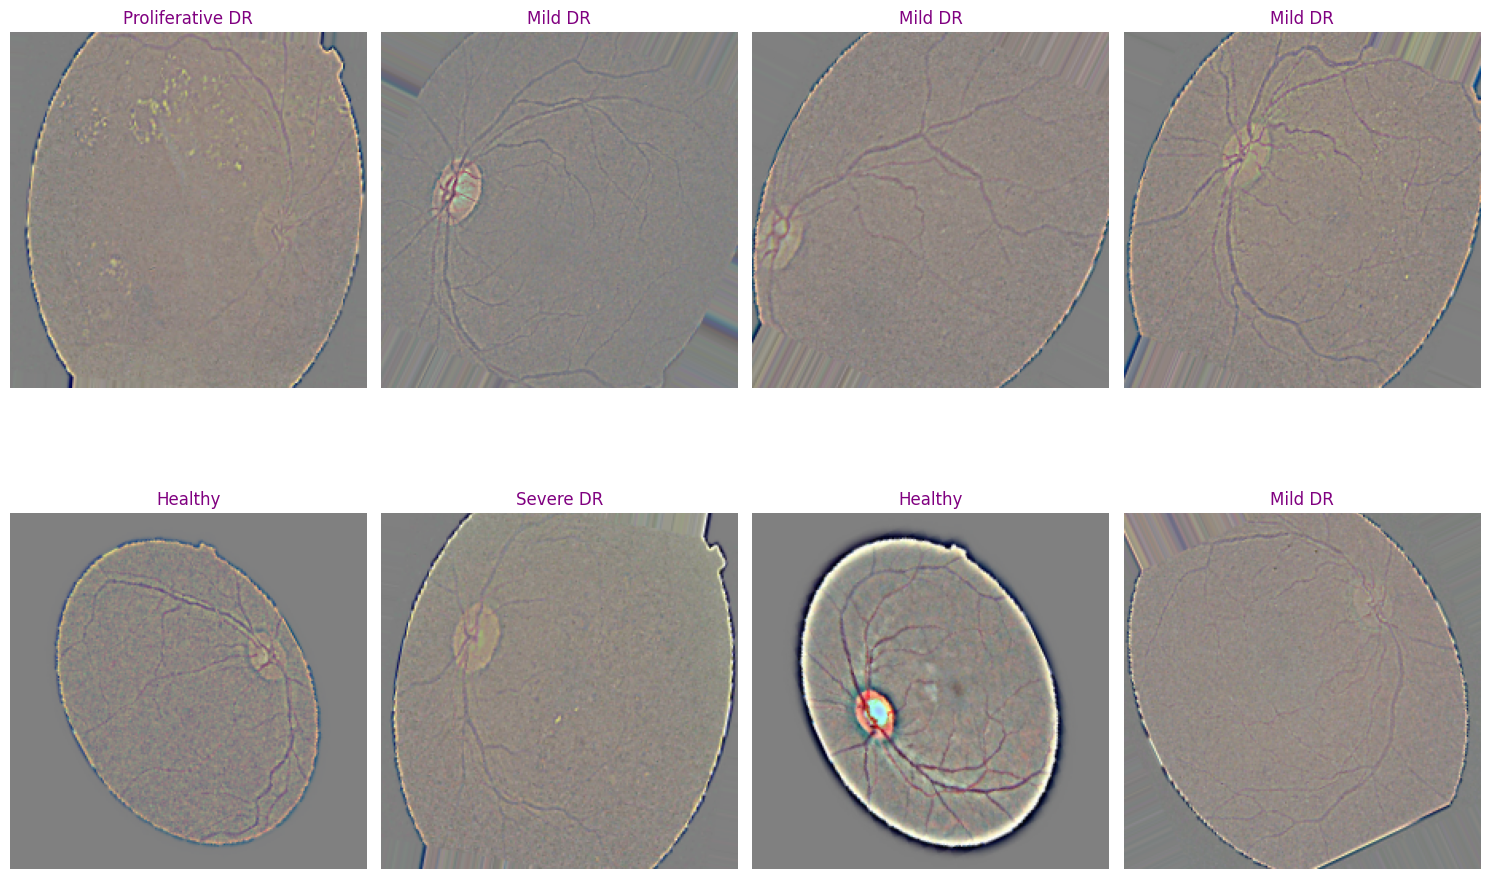

In [10]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Modelling
Transfer learning with EfficientNetB2


In [15]:
# Define number of classes
n_classes = len(list(Train.class_indices.keys()))
n_classes

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l2 = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)
x = Dense(512, kernel_regularizer = regularizers.l2(l2 = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l2 = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(n_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.0001 # start with this learning rate

In [16]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation = 'elu'))
model.add(Dense(5, activation='softmax'))

In [17]:
model.compile(Adamax(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,735,348 (44.77 MB)

 Trainable params: 11,648,045 (44.43 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [19]:
epochs = 50

history = model.fit(x = Train ,epochs = epochs,verbose=1,validation_data = Valid, validation_steps=None,shuffle=False)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1190s 10s/step - acc: 0.4232 - loss: 2.1365 - val_acc: 0.5455 - val_loss: 1.4821
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 401ms/step - acc: 0.5591 - loss: 1.2700 - val_acc: 0.5382 - val_loss: 1.1981
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 46s 418ms/step - acc: 0.6288 - loss: 1.0389 - val_acc: 0.6509 - val_loss: 1.0048
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 395ms/step - acc: 0.6289 - loss: 0.9811 - val_acc: 0.6800 - val_loss: 0.9528
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 395ms/step - acc: 0.6534 - loss: 0.9300 - val_acc: 0.6945 - val_loss: 0.8521
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 43s 393ms/step - acc: 0.6713 - loss: 0.8502 - val_acc: 0.6873 - val_loss: 0.9101
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 46s 414ms/step - acc: 0.6888 - loss: 0.8058 - val_acc: 0.6945 - val_loss: 0.8638
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 399ms/step - acc: 0.7004 - loss: 0.8016 - val_acc: 0.6982 - val_loss: 0.8235
Epoch 9/50
110/110 ━━━━━━━━━━━━━

## Evaluation

In [20]:
# accuracy and loss of Train

tr_acc = history.history['acc']
tr_loss = history.history['loss']


# accuracy and loss or Valid\

v_acc = history.history['val_acc']
v_loss = history.history['val_loss']


# highest value of v_acc by getting its index

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]


# lowest value of v_loss by getting index

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]

# n. of epochs based on length of tr_acc values

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)


# Define best epoch

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

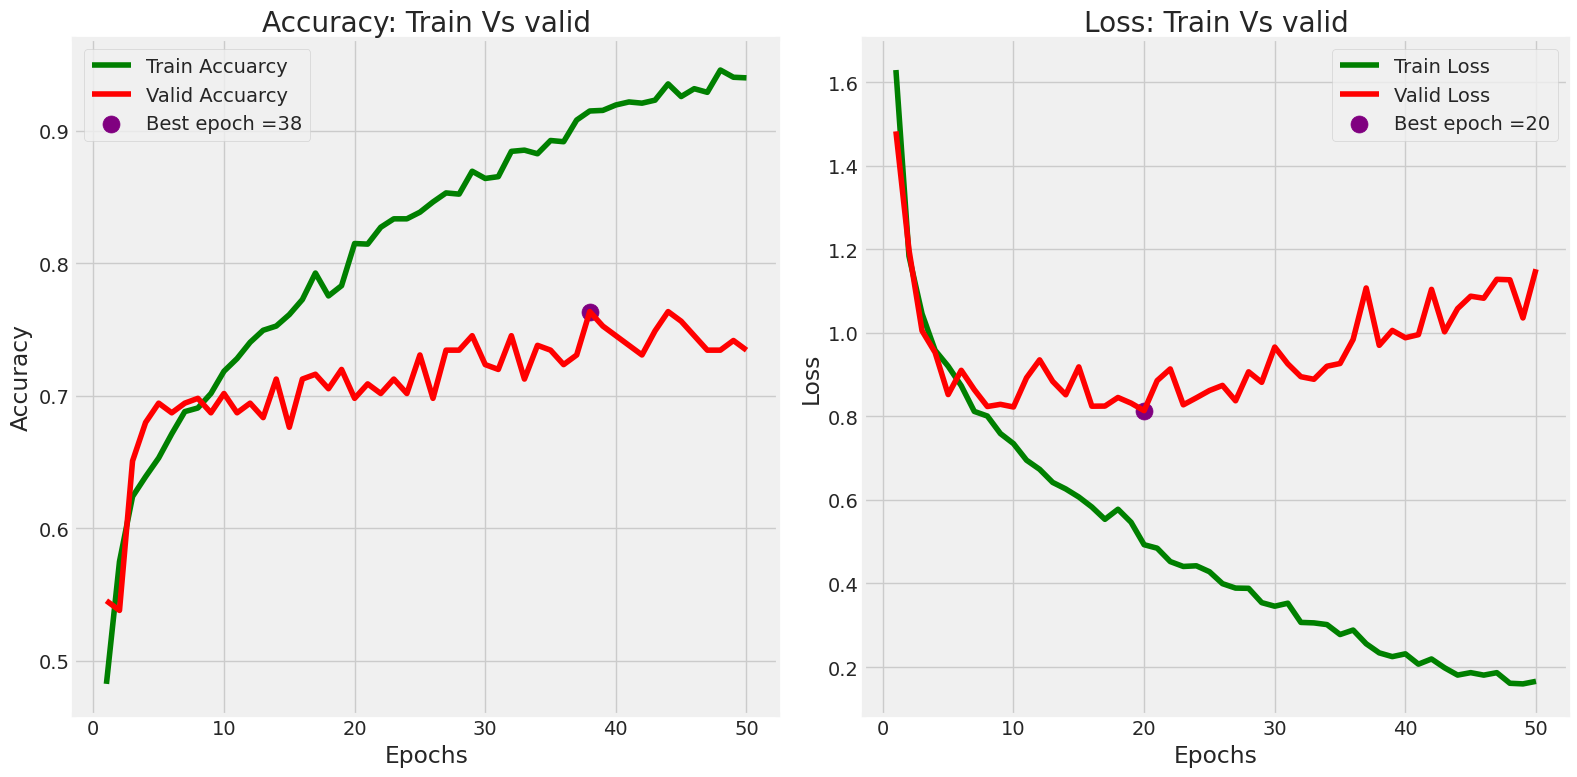

In [21]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Define Vars
Train_sc = model.evaluate(Train, verbose = 1)
Valid_sc = model.evaluate(Valid, verbose = 1)
Test_sc =model.evaluate(Test, verbose = 1)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 339ms/step - acc: 0.9852 - loss: 0.0457
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - acc: 0.7448 - loss: 1.1813
14/14 ━━━━━━━━━━━━━━━━━━━━ 95s 7s/step - acc: 0.7355 - loss: 1.4214
Train Scores : 
    accuracy: 0.9845454692840576 
      Loss:  0.04894023388624191 
________________________
Valid Scores : 
    accuracy: 0.7345454692840576 
      Loss:  1.1520681381225586 
________________________
Test Scores : 
    accuracy: 0.7454545497894287 
      Loss:  1.2171945571899414 
________________________


In [25]:
predictions = model.predict(Test)
y_pred = np.argmax(predictions, axis = 1)

#Chack
print(predictions)
print(y_pred)

14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 825ms/step
[[9.9996972e-01 2.9322039e-06 2.5488345e-05 2.7732105e-07 1.5468097e-06]
 [1.0000000e+00 2.1490940e-09 4.2582559e-16 2.4803057e-16 9.8766868e-21]
 [1.3784473e-02 8.4461033e-01 1.4157997e-01 1.5181708e-05 1.0075393e-05]
 ...
 [3.1726060e-03 1.5480900e-01 6.3326651e-01 2.0590730e-01 2.8445579e-03]
 [9.9999917e-01 8.8551576e-07 3.0908567e-10 8.4794576e-12 4.7644056e-13]
 [5.3093314e-02 4.6686284e-02 7.9779637e-01 9.9308260e-02 3.1156819e-03]]
[0 0 1 2 2 1 3 2 1 1 2 0 0 1 3 1 2 4 2 0 1 0 0 2 2 2 2 0 2 1 2 0 1 2 0 2 2
 2 4 4 1 2 4 0 2 2 0 2 0 2 1 1 1 0 2 0 1 1 2 1 0 2 2 4 2 2 2 2 0 2 0 2 0 0
 2 2 0 4 0 0 1 2 1 2 0 4 0 2 0 1 1 1 4 2 0 2 0 1 2 1 2 2 2 1 0 0 0 0 0 2 1
 2 3 0 0 2 1 0 2 2 0 2 0 2 2 4 2 0 0 2 0 1 1 4 1 2 2 0 1 0 0 1 0 1 0 0 1 0
 0 3 0 0 1 0 2 0 2 2 2 4 2 1 2 2 2 2 0 2 2 0 2 0 4 2 0 2 0 1 4 2 1 0 2 4 1
 0 1 1 2 0 2 0 0 0 0 0 2 1 2 2 2 2 0 2 0 0 2 2 2 0 2 0 2 2 0 0 2 0 1 0 1 2
 2 1 2 1 0 2 0 0 1 0 0 0 1 2 2 0 2 2 1 0 1 2 1 2 0 0 1 0 0 3 2 2

In [26]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices

# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[88,  3,  1,  0,  0],
       [ 3, 30,  8,  0,  0],
       [ 4, 14, 76,  0,  6],
       [ 1,  7,  8,  4,  3],
       [ 0,  1, 10,  1,  7]])

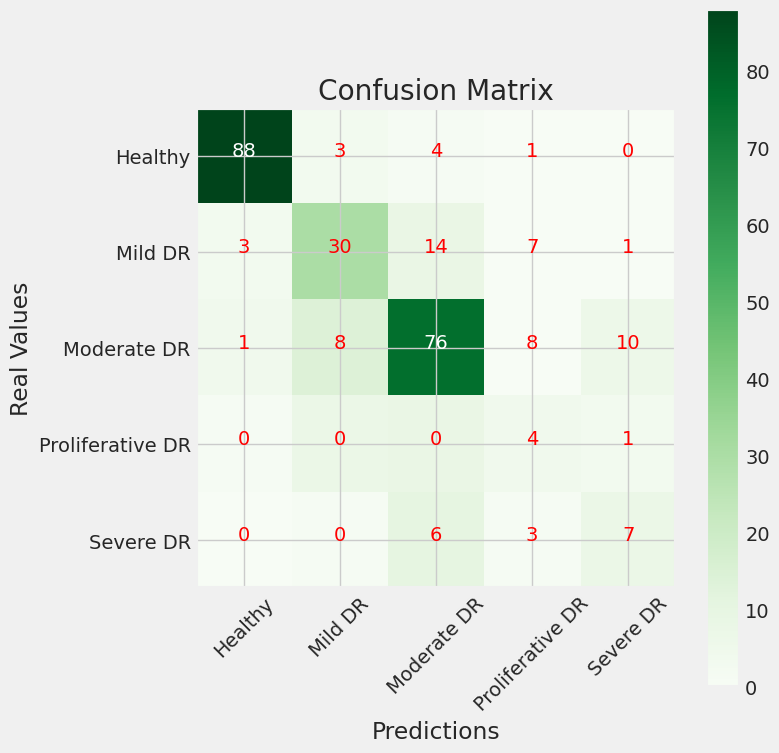

In [27]:
#visualise it
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')

plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()


In [28]:
print(classification_report(Test.classes, y_pred, target_names = classes))

                  precision    recall  f1-score   support

         Healthy       0.92      0.96      0.94        92
         Mild DR       0.55      0.73      0.62        41
     Moderate DR       0.74      0.76      0.75       100
Proliferative DR       0.80      0.17      0.29        23
       Severe DR       0.44      0.37      0.40        19

        accuracy                           0.75       275
       macro avg       0.69      0.60      0.60       275
    weighted avg       0.75      0.75      0.73       275



In [29]:
# Get predictions for the test dataset
test_steps = Test.samples // Test.batch_size
predictions = model.predict(Test, steps=test_steps, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = Test.classes
class_labels = list(Test.class_indices.keys())

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step


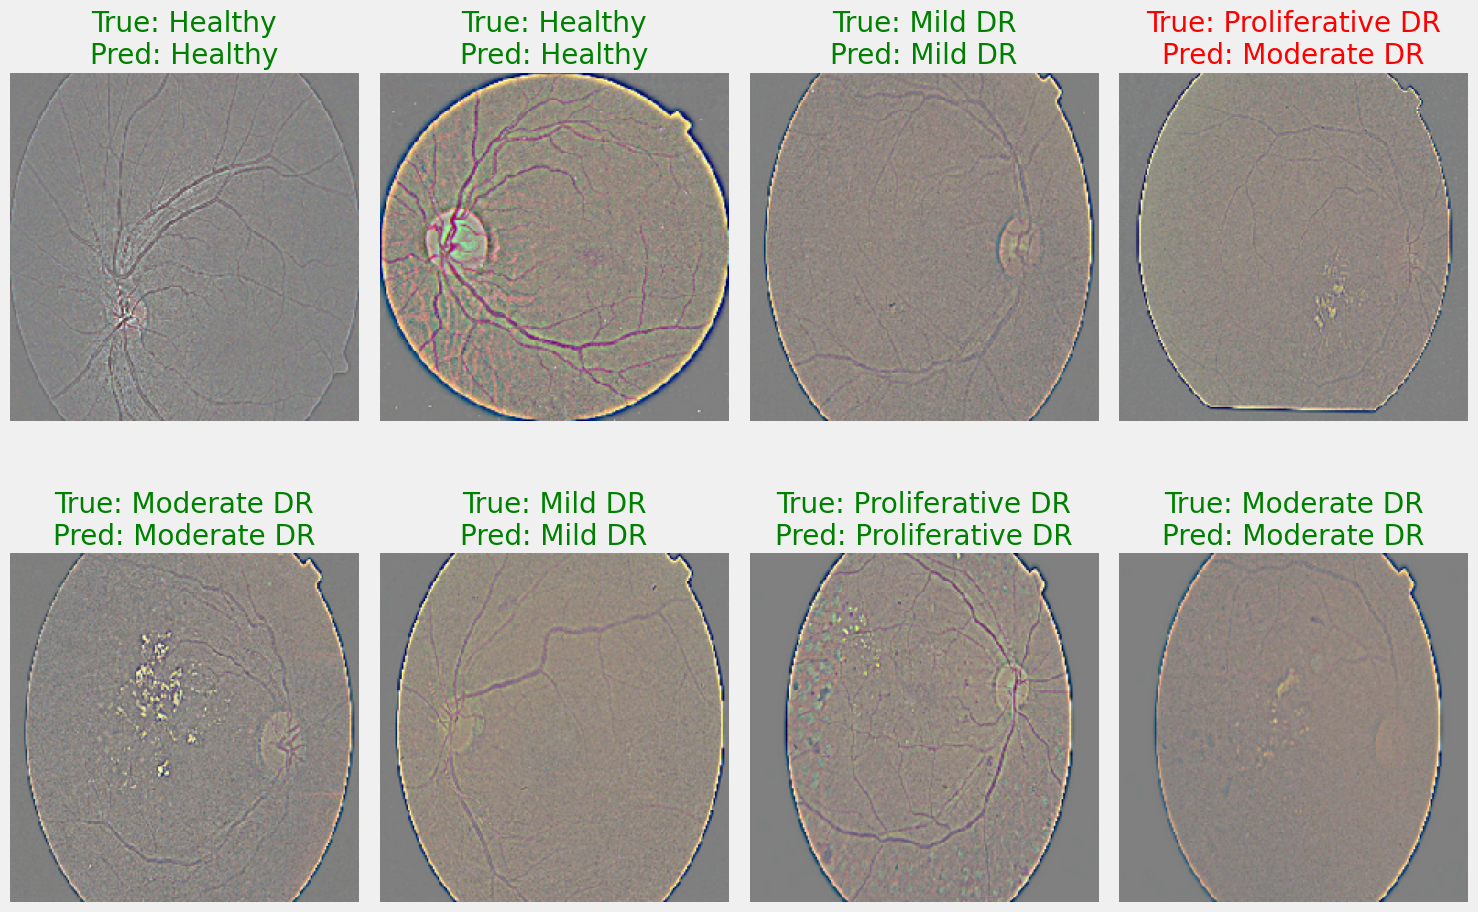

In [30]:
# Visualize a few test images with their predictions
import matplotlib.pyplot as plt

# Get a batch of test images and labels
test_images, test_labels = next(Test)

# Plot the images with their predicted and true labels
plt.figure(figsize=(15, 15))
for i in range(8):
    plt.subplot(3, 4, i + 1)
    img = test_images[i] / 255.0
    plt.imshow(img)

    # Get the true and predicted labels
    true_label_idx = np.argmax(test_labels[i])
    true_label = class_labels[true_label_idx]
    predicted_label_idx = np.argmax(predictions[i])
    predicted_label = class_labels[predicted_label_idx]
 # Set the title with colors indicating correctness
    color = "green" if true_label == predicted_label else "red"
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()